In [ ]:
#!pip install pybinding

In [25]:
import pybinding as pb
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import random
from tqdm import tqdm

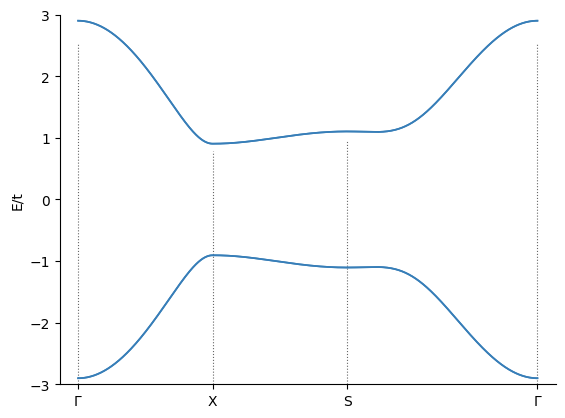

In [26]:
S0=np.array([[1,0],[0,1]])
S1=np.array([[0,1],[1,0]])
S2=np.array([[0,-1j],[1j,0]])
S3=np.array([[1,0],[0,-1]])
from math import pi
g_1 =np.kron(S1,S1)
g_2=np.kron(S1,S2)
g_3=np.kron(S1,S3)
g_4=np.kron(S2,S0)
g_5= np.kron(S3,S0)

D=0.0

DD=1.0
Tx=(1j*g_1+DD*g_5+D*g_4)/2
Ty=(1j*g_2+DD*g_5-D*g_4)/2
U=(0.9*g_5+0.1*g_4)



lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U ))
lat.add_hoppings(
                     ([1,0], 'A', 'A', Tx),
                     ([0,1], 'A', 'A', Ty)
                    )
lattice = lat

model = pb.Model(lat,
        pb.primitive(a1=1,a2=1),
        pb.translational_symmetry(a1=True, a2=True))
solver = pb.solver.lapack(model)


X = [pi,0]
Gamma = [0,0]
Z = [0,pi]
M= [pi,pi]



bands = solver.calc_bands(  Gamma, X, M, Gamma, step=0.01)
bands.plot(point_labels=[ r'$\Gamma$','X', 'S', '$\Gamma$'])
plt.ylabel("E/t")
plt.ylim(-3,3)
plt.xlabel("")
plt.show()

In [27]:
L=40
model = pb.Model(lat,
                 pb.force_double_precision(),
                pb.primitive(L,L),
                pb.translational_symmetry(a1=L, a2=L))
HOB=model.hamiltonian.todense()
print(np.shape(HOB))
EVs=[]
for w in [0.5,1.5]:
        res=[]
        for k in tqdm(range(50)):
            pot=[]
            for j in range(np.shape(HOB)[0]//4):
                pot.append(random.gauss(mu=0.0, sigma=w))
            dis=np.kron(np.diag(pot),np.diag([1,1,1,1]))
            HDis=np.array(HOB+dis)
            evs=np.sort(np.real(cp.asnumpy(cp.linalg.eigvalsh(cp.array(HDis)))))
            res.append(evs)
        EVs.append(res)

(6400, 6400)


100%|██████████| 50/50 [10:28<00:00, 12.57s/it]


In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

EVs=np.array(EVs)

r=[]
for j in tqdm(range(2)):
    rfull=[]
    for en in (np.linspace(-3.,3.,101)):
        ravg=[]
        for k in range(50):
            idx=find_nearest(np.array(EVs)[j,k,:],en)
            for q in range(-10,11,1):
                ravg.append(np.abs(EVs[j,k,idx+q]-EVs[j,k,idx+q-1]))
        rfull.append(np.var(np.array(ravg)/np.mean(ravg)))
    r.append(rfull)

100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


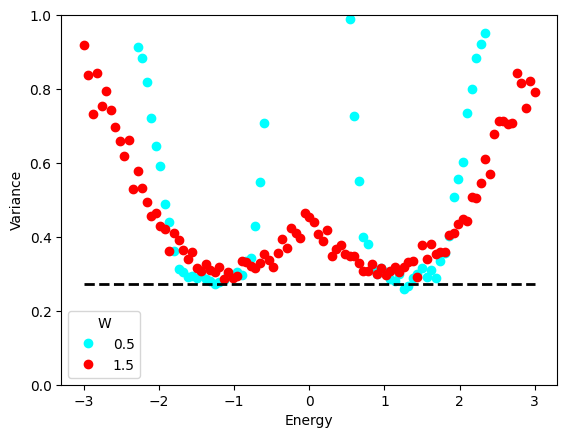

In [29]:
plt.plot(np.linspace(-3.,3.,101),r[0],'o',c='cyan',label='0.5')
plt.plot(np.linspace(-3.,3.,101),r[1],'o',c='red',label='1.5')
plt.plot(np.linspace(-3.,3.,101),.273*np.ones(101),'--',linewidth=2,c='black')
plt.ylim(0,1)
plt.legend(title='W')
plt.ylabel("Variance")
plt.xlabel("Energy")
plt.show()